In [1]:
import cv2
import matplotlib.pyplot as plt
# import pandas as pd
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import keras
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve
import csv
# from module import Model_Training
import shutil
PATH = "/mnt/d/Datasets/"
imgPATH = PATH + "mini-DDSM/MINI-DDSM-Complete-PNG-16/"
ddsm_roi_path = PATH + "CBIS-DDSM/ROI/"
# cbis_ddsm_data_path = PATH + 'CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/'
vindr_roi_path = PATH+"/Vindr-Mammo/ROI/"
data_path = PATH + "mini-DDSM/fullimg/"
save_dir = "/home/jj/FYP/Models/"
combined_path = PATH + "combined/"
full_img_path = '/mnt/d/Datasets/INbreast/full/'
roi_img_path = '/mnt/d/Datasets/INbreast/ROI/'
image_size = 300
img_height = 300
img_width = 300
batch_size = 16



os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-02-16 23:40:11.183123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 23:40:11.678406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jj/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-16 23:40:11.678491: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

Num GPUs Available:  1


2023-02-16 23:40:12.226645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-16 23:40:12.233285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-16 23:40:12.233320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# load ddsm

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  # validation_split=0.2,
  # subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  # validation_split=0.2,
  # subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 329 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


In [2]:
preprocessing = preprocess_input
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
pre_trained.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.2),fill_mode='reflect'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='reflect'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='reflect')
  ])
#Define model architect
tfinput = Input(shape=(img_height,img_width,3))
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
inceptionv3_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(inceptionv3_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=)(x)
x = Dense(8,activation='relu')(x)
# ,kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)

model = Model(tfinput,output)
model.summary()

SyntaxError: invalid syntax (2778411699.py, line 23)

In [ ]:
# @tf.function
AUTOTUNE = tf.data.AUTOTUNE
def fetch(data):
    # data=data.cache()
    data = data.batch(4)
    data=data.prefetch(buffer_size=AUTOTUNE)
    return data

In [ ]:
train_ds_aug = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_aug= val_ds.prefetch(buffer_size=AUTOTUNE)

# train_ds_aug = fetch(train_ds)
# val_ds_aug= fetch(val_ds)

In [ ]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f'Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')

# initialising

In [ ]:
optimiser_Adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimiser_Adam.lr = 1e-3
model.compile(
    optimizer= optimiser_Adam,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.AUC()]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_inbreast_roi/dense_init_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0     

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1638

In [8]:
new_dict = {'Epoch','train_loss','train_accuracy','val_loss','val_accuracy'}
log = open('2INbreast_InceptionV3_Dense_Training.csv', 'a')
writer = csv.writer(log)
writer.writerow(new_dict)
log.close()

2023-02-15 15:48:14.300657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-15 15:48:15.806495: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-15 15:48:15.806541: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-15 15:48:16.333446: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

20/21 [===========================>..] - ETA: 0s - loss: 0.5954 - categorical_accuracy: 0.6281 - precision: 0.5920 - precision_1: 0.6713 - auc: 0.7374

2023-02-15 15:48:20.157708: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-15 15:48:20.157758: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


21/21 [==============================] - ETA: 0s - loss: 0.5911 - categorical_accuracy: 0.6261 - precision: 0.5866 - precision_1: 0.6735 - auc: 0.7409

2023-02-15 15:48:20.646895: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-15 15:48:20.646941: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Epoch 0: accuracy=0.6261, loss=0.5911, val_accuracy=0.8125, val_loss=0.4295,  - lr=0.0001000
21/21 [==============================] - 14s 246ms/step - loss: 0.5911 - categorical_accuracy: 0.6261 - precision: 0.5866 - precision_1: 0.6735 - auc: 0.7409 - val_loss: 0.4295 - val_categorical_accuracy: 0.8125 - val_precision: 0.8571 - val_precision_1: 0.7778 - val_auc: 0.9090
Epoch 2/2
21/21 [==============================] - 4s 175ms/step - loss: 0.4670 - categorical_accuracy: 0.7234 - precision: 0.7319 - precision_1: 0.7173 - auc: 0.8212 - val_loss: 0.3541 - val_categorical_accuracy: 0.8625 - val_precision: 0.9143 - val_precision_1: 0.8222 - val_auc: 0.9294
Epoch 3/3
21/21 [==============================] - 4s 174ms/step - loss: 0.4803 - categorical_accuracy: 0.7964 - precision: 0.8860 - precision_1: 0.7488 - auc: 0.8565 - val_loss: 0.3753 - val_categorical_accuracy: 0.7750 - val_precision: 1.0000 - val_precision_1: 0.6897 - val_auc: 0.9106
Epoch 4/4
21/21 [==============================] 

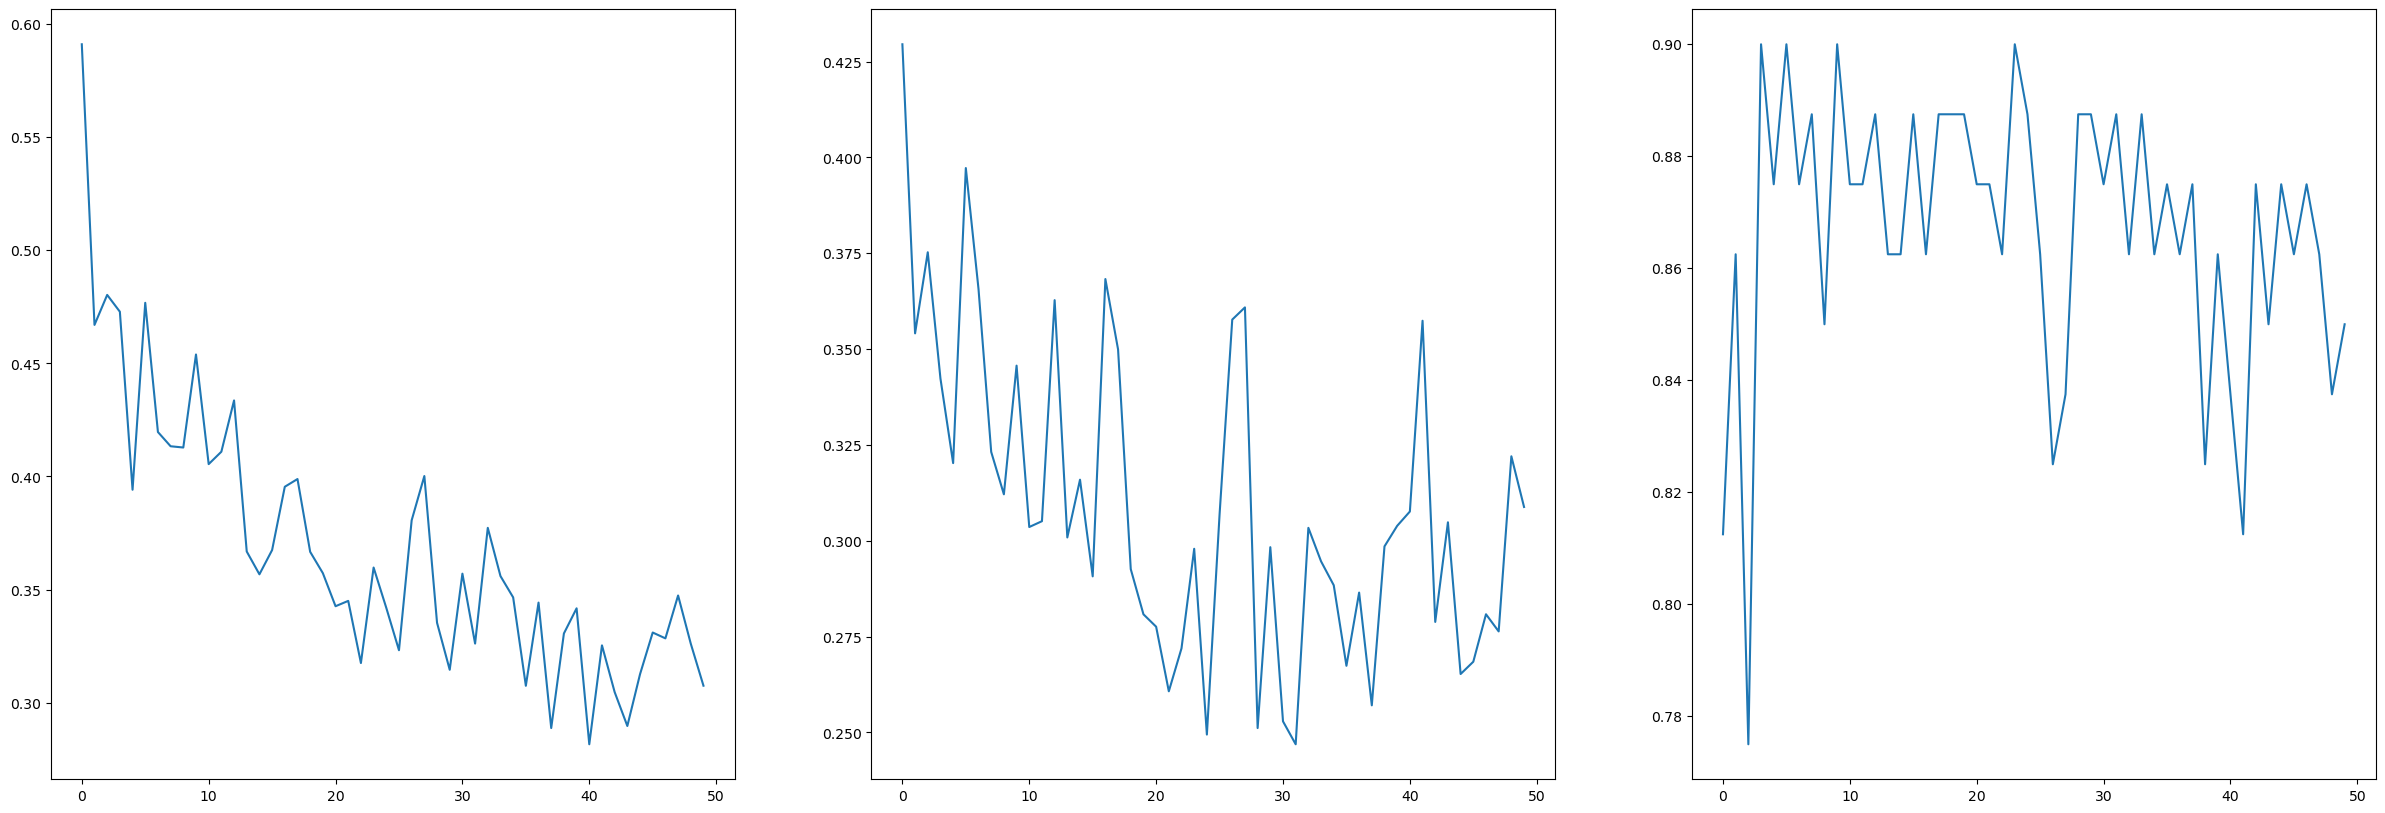

In [9]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
# Progress_bar = tf.keras.callbacks.ProgbarLogger()
# to_CSV = tf.keras.callbacks.CSVLogger('INbreast_InceptionV3_Dense_Training')
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
with tf.device('/GPU:0'):
    total_epochs=50
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser_Adam.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        all_history['train_loss'].append(history.history['loss'][-1])
        all_history['train_acc'].append(history.history['categorical_accuracy'][-1])
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(history.history['val_categorical_accuracy'][-1])
        patience = 5
        # Earlystop = 5
        log = open('2INbreast_InceptionV3_Dense_Training.csv', 'a')
        new_dict = {'Epoch':i+1,'train_loss':history.history['loss'][-1],'train_accuracy':history.history['categorical_accuracy'][-1],
        'val_loss':val_loss,'val_accuracy':history.history['val_categorical_accuracy'][-1]}
        writer = csv.DictWriter(log, fieldnames=list(new_dict.keys()))
        writer.writerow(new_dict)
        log.close()
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model.get_weights()
            model.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_INbreast_roi_2/dense_init_checkpoint_2/best_model")
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model
            model.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser_Adam.lr > min_lr:
                optimiser_Adam.lr = optimiser_Adam.lr * 0.1
            # Reset the patience counter
            patience_counter = 0
# model.save(save_dir + "inceptionv3")

plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

# fine tuning

In [10]:
preprocessing = preprocess_input
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
#Define model architect
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-63]:
  layer.trainable = False
tfinput = Input(shape=(img_height,img_width,3))
# data_augment = data_augmentation(tfinput)
pre_process = preprocessing(tfinput)
inceptionv3_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(inceptionv3_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model_fine = Model(tfinput,output)
model_fine.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 8)                 104858

In [11]:
new_dict = {'Epoch','train_loss','train_accuracy','val_loss','val_accuracy'}
log = open('2INbreast_InceptionV3_FineTuning.csv', 'a')
writer = csv.writer(log)
writer.writerow(new_dict)
log.close()

21/21 [==============================] - 5s 101ms/step - loss: 1.1452 - categorical_accuracy: 0.8419 - precision: 0.9725 - precision_1: 0.7773 - val_loss: 1.0207 - val_categorical_accuracy: 0.8875 - val_precision: 0.9189 - val_precision_1: 0.8605
Epoch 2/2
21/21 [==============================] - 2s 64ms/step - loss: 1.1341 - categorical_accuracy: 0.8450 - precision: 0.9561 - precision_1: 0.7860 - val_loss: 1.0267 - val_categorical_accuracy: 0.9125 - val_precision: 0.9231 - val_precision_1: 0.9024
Epoch 3/3
21/21 [==============================] - 2s 64ms/step - loss: 1.1186 - categorical_accuracy: 0.8723 - precision: 0.9748 - precision_1: 0.8143 - val_loss: 1.0475 - val_categorical_accuracy: 0.8625 - val_precision: 1.0000 - val_precision_1: 0.7843
Epoch 4/4
21/21 [==============================] - 1s 63ms/step - loss: 1.1024 - categorical_accuracy: 0.8419 - precision: 1.0000 - precision_1: 0.7699 - val_loss: 0.9798 - val_categorical_accuracy: 0.9125 - val_precision: 0.9714 - val_preci

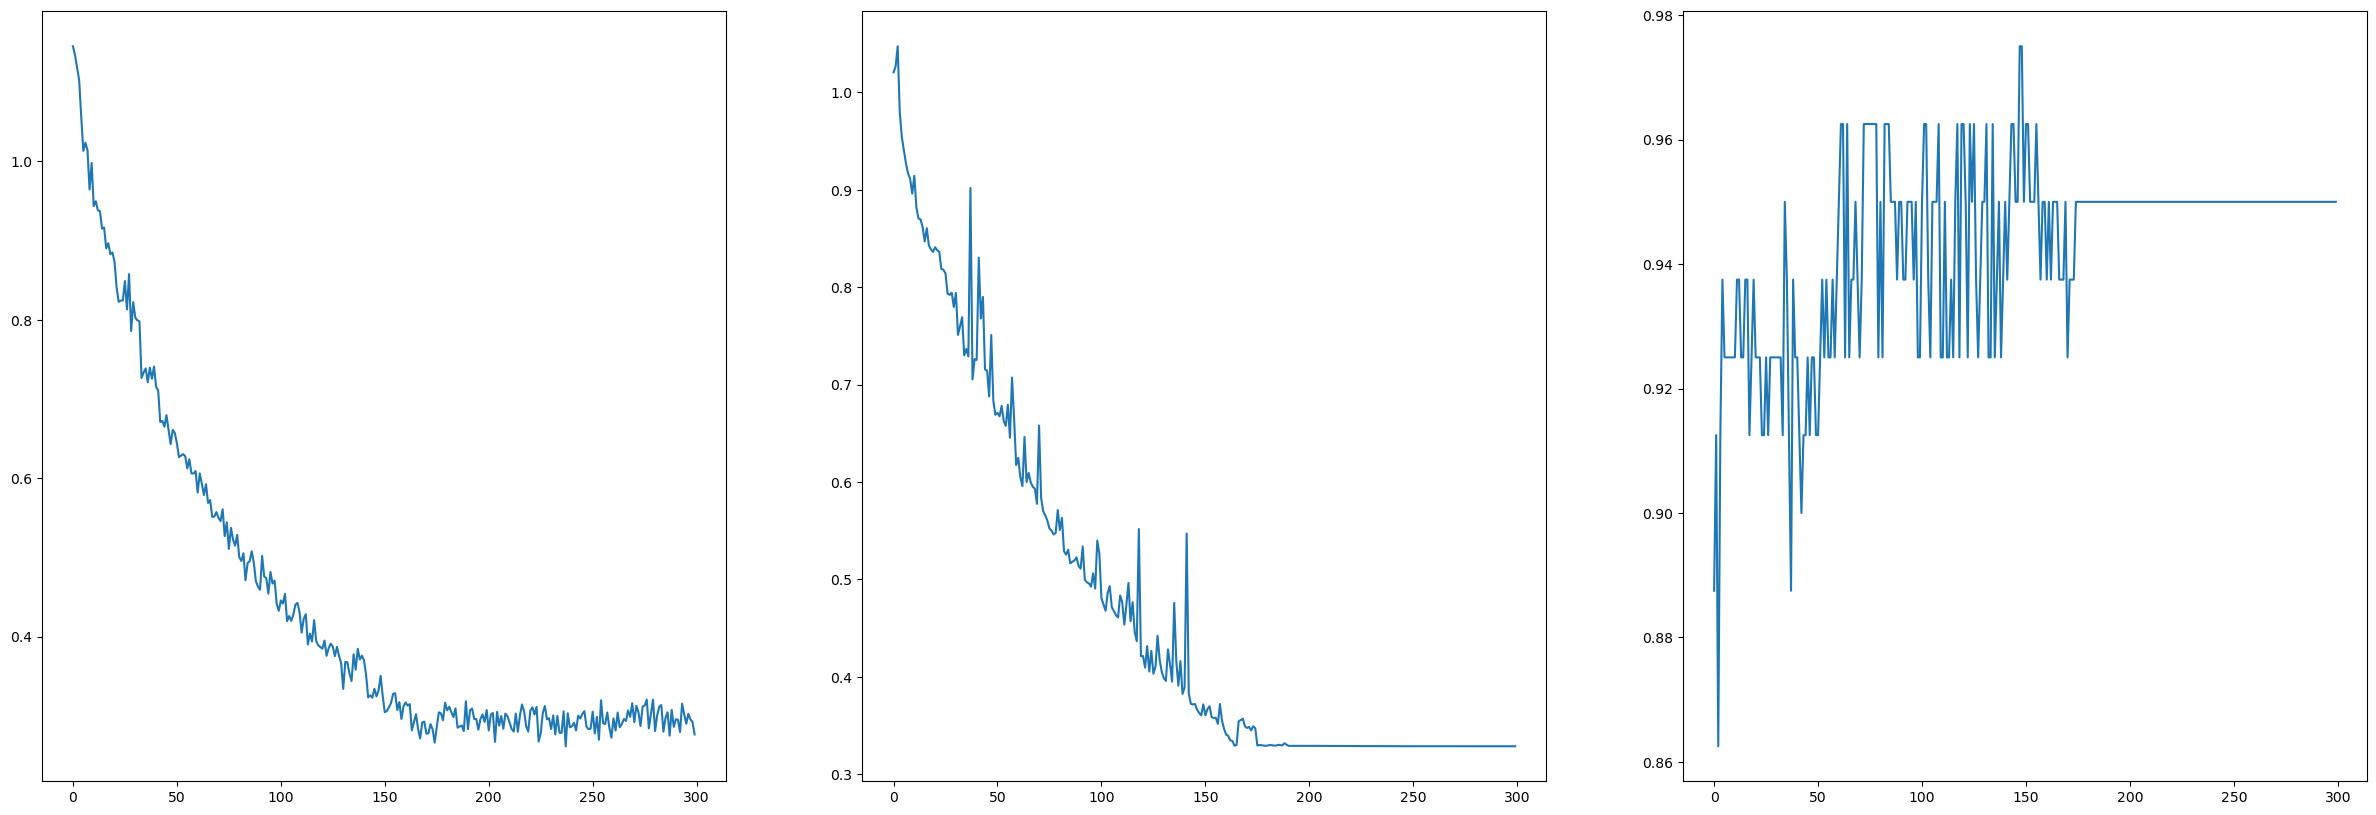

In [15]:
#load model_fine with best performance
# model_fine.load_weights("/home/jj/FYP/Checkpoint/EfficientNet/dense_init_checkpoint/cp-0010.ckpt")
# tf.keras.backend.clear_session()
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/InceptionV3_INbreast_roi_2/dense_init_checkpoint_2')
# model_fine.load_weights('/home/jj/FYP/Checkpoint/InceptionV3_INbreast_roi/fine_tuning_checkpoint_loss_2/best_model')
model_fine.load_weights(latest)
optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
model_fine.compile(
    optimizer= optimiser,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-6,verbose=1)
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
earlystop_counter = 0
with tf.device('/GPU:0'):
    total_epochs=300
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model_fine.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        val_categorical_accuracy = history.history['val_categorical_accuracy'][-1]
        loss = history.history['loss'][-1]
        categorical_accuracy = history.history['categorical_accuracy'][-1]
        all_history['train_loss'].append(loss)
        all_history['train_acc'].append(categorical_accuracy)
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(val_categorical_accuracy)
        patience = 10
        Earlystop = 100
        log = open('2INbreast_InceptionV3_FineTuning.csv', 'a')
        writer = csv.writer(log)
        new_dict = [i+1,history.history['loss'][-1],history.history['categorical_accuracy'][-1],val_loss,history.history['val_categorical_accuracy'][-1]]
        # writer = csv.DictWriter(log, fieldnames=list(new_dict.keys()))
        writer.writerow(new_dict)
        log.close()
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model_fine.get_weights()
            model_fine.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_INbreast_roi/fine_tuning_checkpoint_loss_2/best_model")
            best_val_loss = val_loss
            patience_counter = 0
            earlystop_counter = 0
        else:
            patience_counter += 1
            earlystop_counter +=1

        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model_fine
            model_fine.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser.lr > min_lr:
                optimiser.lr = optimiser.lr * 0.1
            # Reset the patience counter
            patience_counter = 0
        if earlystop_counter == Earlystop:
            print(f'Early Stop at Epoch: {i+1}')
            break
# model_fine.set_weights(best_weights)
# model_fine.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_loss/best_model")

plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

In [16]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 72 files belonging to 2 classes.


In [28]:
# plt.figure(figsize=(20,40))
# prediction = model_fine.make_predict_function(force = True)
# for i,filename in enumerate(os.listdir(roi_img_path+'test/benign/')):
    # image = tf.io.read_file(roi_img_path+'test/benign/'+filename)
    # full_image = tf.image.decode_png(image, channels=3)
    # image = tf.keras.preprocessing.image.img_to_array(full_image)
    # image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # image = tf.data.Dataset.from_tensor_slices((image,image))
    # predict = model_fine.predict(image,verbose=0)
    # print(predict)
    # plt.subplot(10,8,i+1)
    # plt.imshow(full_image)
    # plt.title(str(filename))
    # plt.xlabel('Prediction: \n' + str(predict))

In [20]:
model_fine.evaluate(test_ds)

5/5 [==============================] - 1s 38ms/step - loss: 0.6733 - categorical_accuracy: 0.8750 - precision: 0.8868 - precision_1: 0.8421


[0.6733354926109314, 0.875, 0.8867924809455872, 0.8421052694320679]

In [19]:
predict = model_fine.predict(test_ds)
predict

5/5 [==============================] - 0s 76ms/step


array([[1.00000000e+00, 2.46398336e-11],
       [7.78997317e-03, 9.92210031e-01],
       [9.85380352e-01, 1.46196540e-02],
       [1.00000000e+00, 1.12859356e-14],
       [9.99380112e-01, 6.19863451e-04],
       [9.99867439e-01, 1.32538000e-04],
       [1.00000000e+00, 4.94070100e-08],
       [1.00000000e+00, 1.05645041e-11],
       [9.99991775e-01, 8.27194344e-06],
       [9.98838246e-01, 1.16181106e-03],
       [1.72489963e-04, 9.99827504e-01],
       [1.00000000e+00, 3.61694958e-08],
       [1.00000000e+00, 4.35317879e-13],
       [9.99244332e-01, 7.55641027e-04],
       [2.30552496e-06, 9.99997735e-01],
       [1.00000000e+00, 8.43133140e-14],
       [9.99999881e-01, 1.45016813e-07],
       [9.99994516e-01, 5.49771448e-06],
       [1.80700148e-08, 1.00000000e+00],
       [1.00000000e+00, 3.83620436e-13],
       [9.98604357e-01, 1.39568117e-03],
       [1.00000000e+00, 9.91969636e-13],
       [2.00905888e-05, 9.99979854e-01],
       [1.00000000e+00, 1.37111107e-13],
       [9.999969

In [17]:
# predict = model_fine.predict(test_ds)
# model_fine.compile(
    # optimizer= 'adam',
    # loss=tf.keras.losses.CategoricalCrossentropy(),
    # metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
# )
model_fine.load_weights('/home/jj/FYP/Checkpoint/InceptionV3_INbreast_roi/fine_tuning_checkpoint_loss_2/best_model')
model_fine.evaluate(test_ds)
# labels = np.zeros((72,2))
# i=0
# for x,label in test_ds:
    # for l in label:
        # labels[i] = l.numpy()
        # i+=1

5/5 [==============================] - 1s 61ms/step - loss: 0.6734 - categorical_accuracy: 0.8750 - precision: 0.8868 - precision_1: 0.8421


[0.6733826398849487, 0.875, 0.8867924809455872, 0.8421052694320679]

In [30]:
# malignant_pred = predict[:,0]
# benign_pred = predict[:,1]
# mal_label = labels[:,0]
# ben_label = labels[:,1]

In [31]:
# fpr_m, tpr_m, threshold_m = roc_curve(ben_label,benign_pred)
# from sklearn.metrics import auc
# auc_rf = auc(fpr_m, tpr_m)
# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_m, tpr_m, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

In [32]:
# model_fine.load_weights('/home/jj/FYP/Checkpoint/InceptionV3_INbreast_roi/fine_tuning_checkpoint_loss_2/best_model')
# eval = model_fine.evaluate(test_ds)
# predict = model_fine.predict(test_ds)
# true_label =[]
# for x,label in test_ds:
    # true_label.append(label)
# def get_file_name(example):
    # return example['file_name'].numpy().decode("utf-8")
# 
# test_ds = test_ds.map(lambda x, y: (get_file_name(x), y))
# 
# Iterate over the elements of the test_ds
# for file_name, label in test_ds:
    # print("File name: ", file_name)
    # print("Label: ", label)
# print()


# EfficientNet

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1024008   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                           

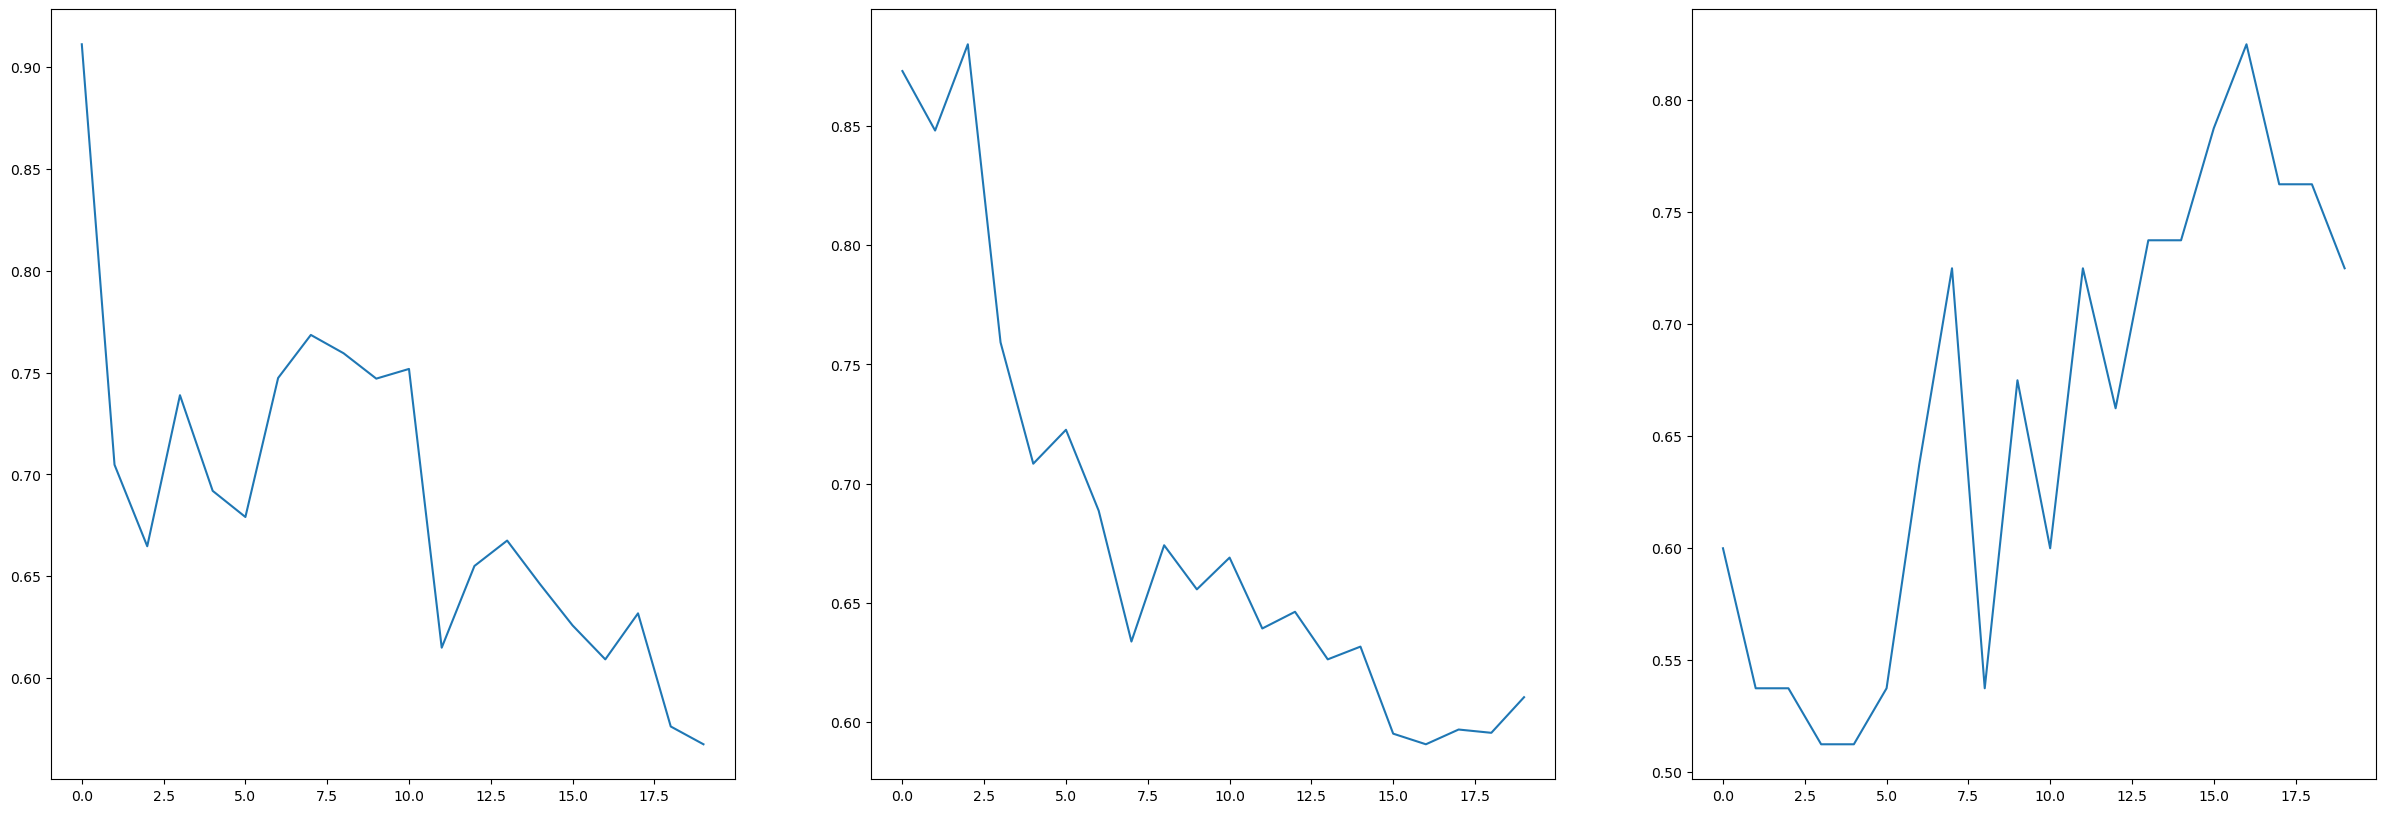

In [35]:
preprocessing = tf.keras.applications.efficientnet_v2.preprocess_input
pre_trained = tf.keras.applications.efficientnet_v2.EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
pre_trained.trainable = False
#Define model architect
tfinput = Input(shape=(img_height,img_width,3))
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
effnet_2M_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(effnet_2M_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu')(x)
# ,kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model = Model(tfinput,output)
model.summary()
optimiser_Adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer= optimiser_Adam,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.AUC()]
    # ,jit_compile=True
)
new_dict = {'Epoch','train_loss','train_accuracy','val_loss','val_accuracy'}
log = open('INbreast_EfficientNetV2M_Dense_Training.csv', 'a')
writer = csv.writer(log)
writer.writerow(new_dict)
log.close()
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
# Progress_bar = tf.keras.callbacks.ProgbarLogger()
# to_CSV = tf.keras.callbacks.CSVLogger('INbreast_InceptionV3_Dense_Training')
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
with tf.device('/GPU:0'):
    total_epochs=20
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser_Adam.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        all_history['train_loss'].append(history.history['loss'][-1])
        all_history['train_acc'].append(history.history['categorical_accuracy'][-1])
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(history.history['val_categorical_accuracy'][-1])
        patience = 1
        log = open('INbreast_EfficientNetV2M_Dense_Training.csv', 'a')
        new_dict = {'Epoch':i+1,'train_loss':history.history['loss'][-1],'train_accuracy':history.history['categorical_accuracy'][-1],
        'val_loss':val_loss,'val_accuracy':history.history['val_categorical_accuracy'][-1]}
        writer = csv.DictWriter(log, fieldnames=list(new_dict.keys()))
        writer.writerow(new_dict)
        log.close()
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model.get_weights()
            model.save_weights("/home/jj/FYP/Checkpoint/EfficientNetV2M_INbreast_roi/dense_init_checkpoint/best_model")
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model
            model.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser_Adam.lr > min_lr:
                optimiser_Adam.lr = optimiser_Adam.lr * 0.9
            # Reset the patience counter
            patience_counter = 0
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 8)                 1024008   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                             

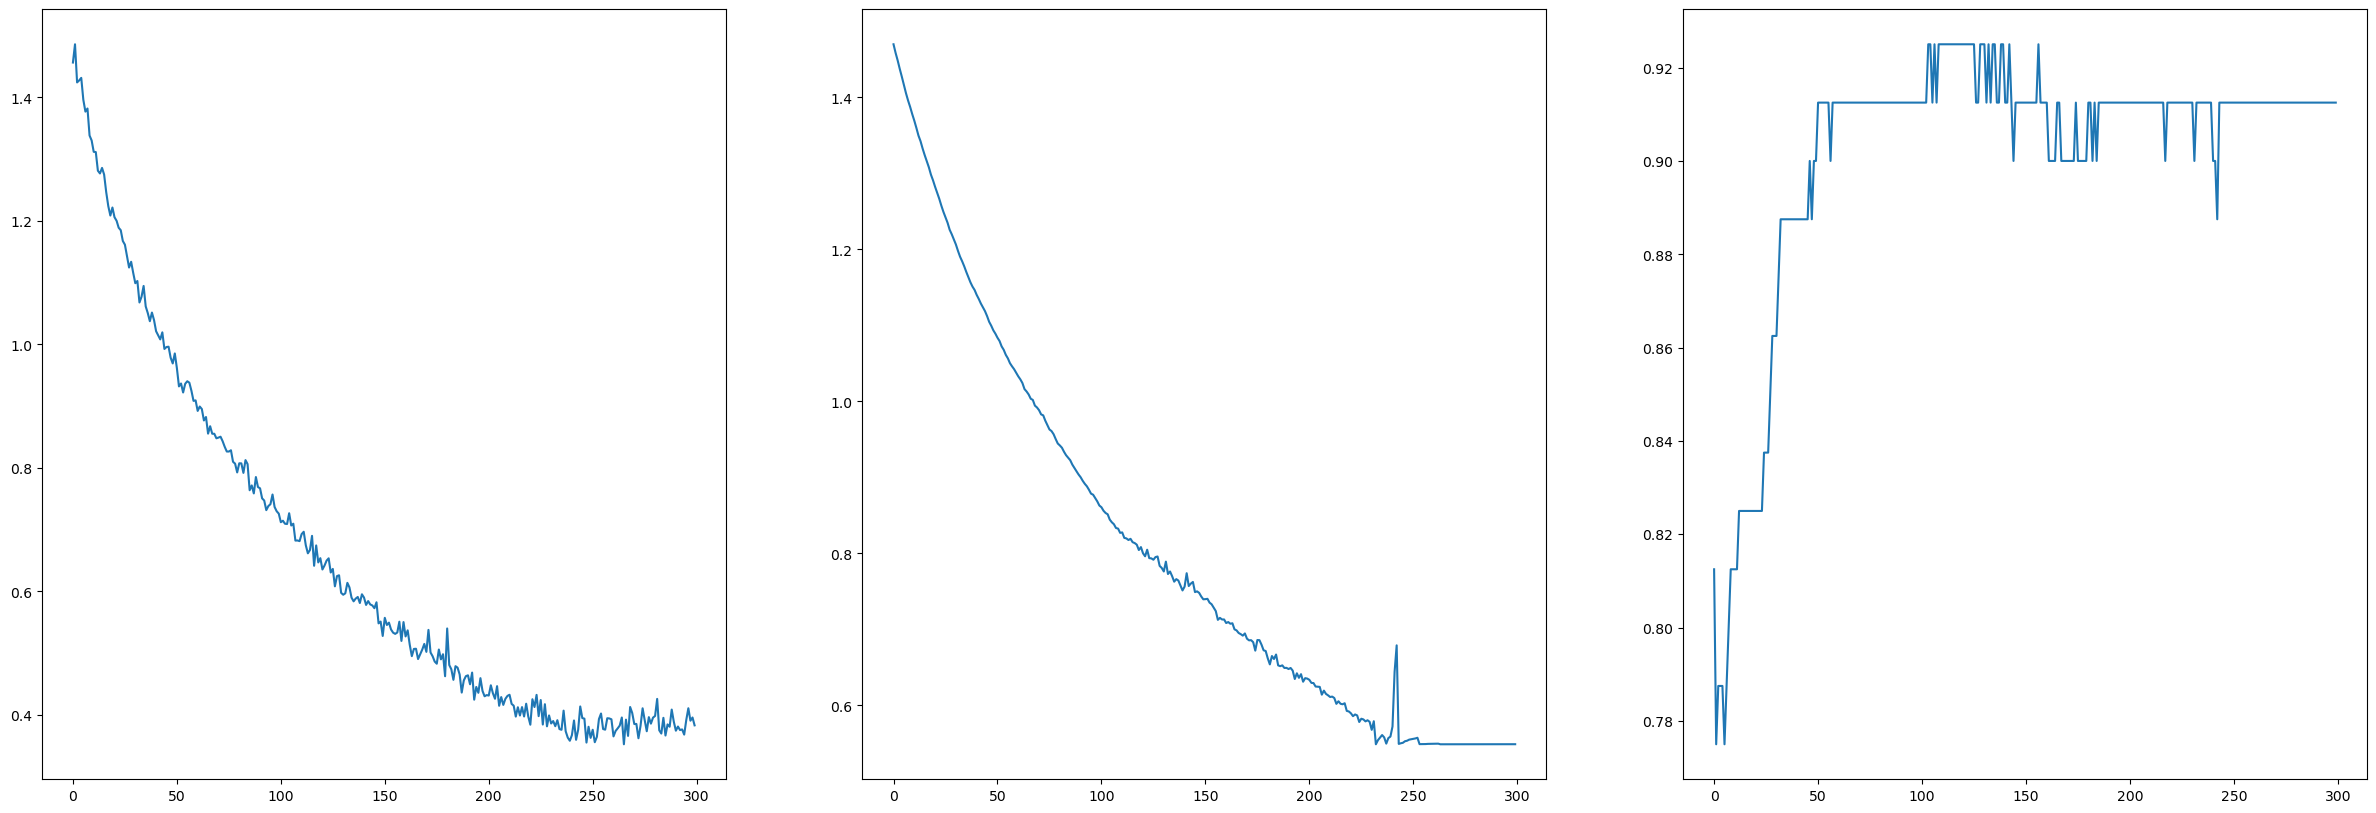

In [36]:
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-75]:
  layer.trainable = False
tfinput = Input(shape=(img_height,img_width,3))
# data_augment = data_augmentation(tfinput)
pre_process = preprocessing(tfinput)
inceptionv3_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(inceptionv3_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model_fine = Model(tfinput,output)
model_fine.summary()
new_dict = {'Epoch','train_loss','train_accuracy','val_loss','val_accuracy'}
log = open('INbreast_EfficientNetV2M_FineTuning.csv', 'a')
writer = csv.writer(log)
writer.writerow(new_dict)
log.close()
model_fine.load_weights("/home/jj/FYP/Checkpoint/EfficientNetV2M_INbreast_roi/dense_init_checkpoint/best_model")
optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
model_fine.compile(
    optimizer= optimiser,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-6,verbose=1)
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
with tf.device('/GPU:0'):
    total_epochs=300
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model_fine.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        val_categorical_accuracy = history.history['val_categorical_accuracy'][-1]
        loss = history.history['loss'][-1]
        categorical_accuracy = history.history['categorical_accuracy'][-1]
        all_history['train_loss'].append(loss)
        all_history['train_acc'].append(categorical_accuracy)
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(val_categorical_accuracy)
        patience = 10
        Earlystop = 40
        log = open('INbreast_EfficientNetV2M_FineTuning.csv', 'a')
        writer = csv.writer(log)
        new_dict = [i+1,history.history['loss'][-1],history.history['categorical_accuracy'][-1],val_loss,history.history['val_categorical_accuracy'][-1]]
        # writer = csv.DictWriter(log, fieldnames=list(new_dict.keys()))
        writer.writerow(new_dict)
        log.close()
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model_fine.get_weights()
            model_fine.save_weights("/home/jj/FYP/Checkpoint/EfficientNetV2M_INbreast_roi/fine_tuning_checkpoint_loss/best_model")
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model_fine
            model_fine.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser.lr > min_lr:
                optimiser.lr = optimiser.lr * 0.1
            # Reset the patience counter
            patience_counter = 0
# model_fine.set_weights(best_weights)
# model_fine.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_loss/best_model")

plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

In [43]:
model_fine.load_weights('/home/jj/FYP/Checkpoint/EfficientNetV2M_INbreast_roi/fine_tuning_checkpoint_loss/best_model')
eval = model_fine.evaluate(test_ds)

ValueError: Received incompatible tensor with shape (3, 3, 3, 24) when attempting to restore variable with shape (7, 7, 3, 64) and name layer_with_weights-0/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE.

# Resnet50

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_2 (Flatten)         (None, 204800)            0   

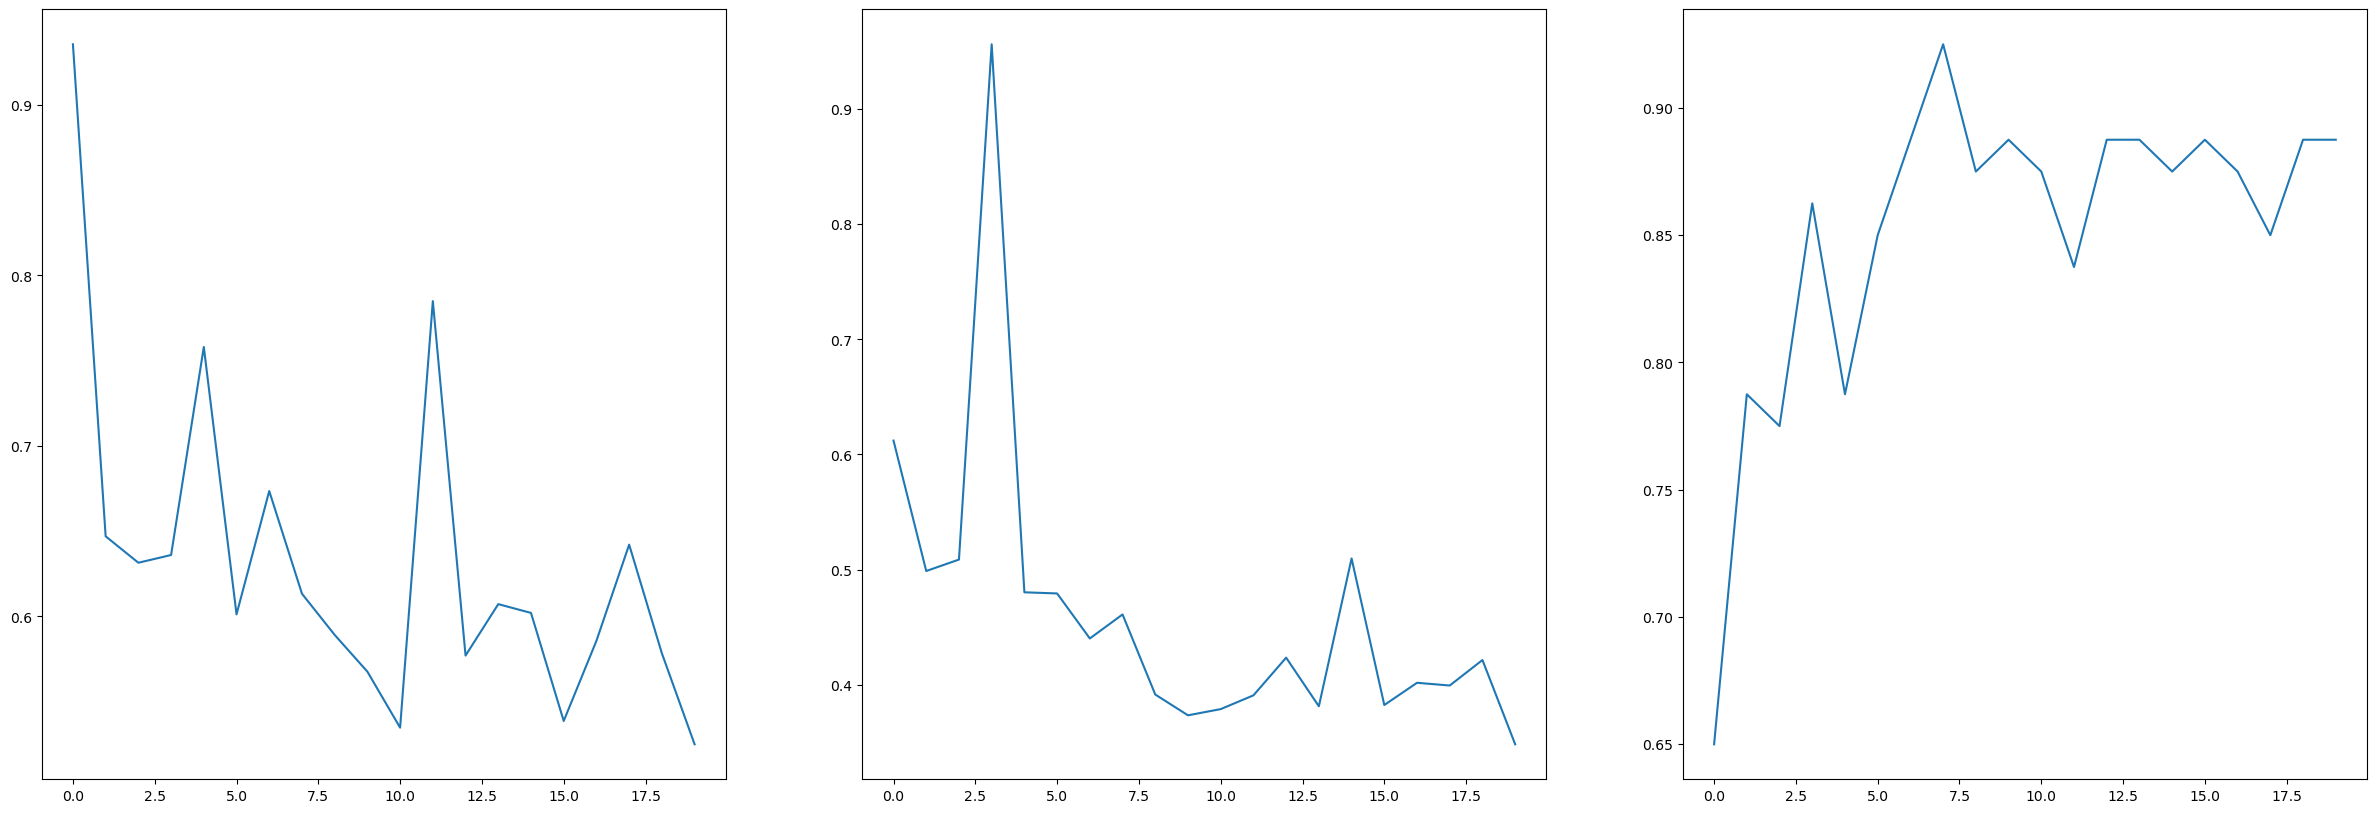

In [39]:
preprocessing = tf.keras.applications.resnet50.preprocess_input
pre_trained = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
pre_trained.trainable = False
#Define model architect
tfinput = Input(shape=(img_height,img_width,3))
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
resnet50_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(resnet50_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu')(x)
# ,kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model = Model(tfinput,output)
model.summary()
optimiser_Adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer= optimiser_Adam,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.AUC()]
    # ,jit_compile=True
)
new_dict = {'Epoch','train_loss','train_accuracy','val_loss','val_accuracy'}
log = open('INbreast_resnet_dense_training.csv', 'a')
writer = csv.writer(log)
writer.writerow(new_dict)
log.close()
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
# Progress_bar = tf.keras.callbacks.ProgbarLogger()
# to_CSV = tf.keras.callbacks.CSVLogger('INbreast_InceptionV3_Dense_Training')
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
with tf.device('/GPU:0'):
    total_epochs=20
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser_Adam.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        all_history['train_loss'].append(history.history['loss'][-1])
        all_history['train_acc'].append(history.history['categorical_accuracy'][-1])
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(history.history['val_categorical_accuracy'][-1])
        patience = 5
        log = open('INbreast_resnet_dense_training.csv', 'a')
        new_dict = {'Epoch':i+1,'train_loss':history.history['loss'][-1],'train_accuracy':history.history['categorical_accuracy'][-1],
        'val_loss':val_loss,'val_accuracy':history.history['val_categorical_accuracy'][-1]}
        writer = csv.DictWriter(log, fieldnames=list(new_dict.keys()))
        writer.writerow(new_dict)
        log.close()
        patience = 1
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model.get_weights()
            model.save_weights("/home/jj/FYP/Checkpoint/Resnet50_INbreast_roi/dense_init_checkpoint/best_model")
            best_val_loss = val_loss
            patience_counter =0
           
        else:
            patience_counter += 1
           
        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model_fine
            model.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser.lr > min_lr:
                optimiser.lr = optimiser.lr * 0.9
            # Reset the patience counter
            patience_counter = 0
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 8)                 1638408   
                                                             

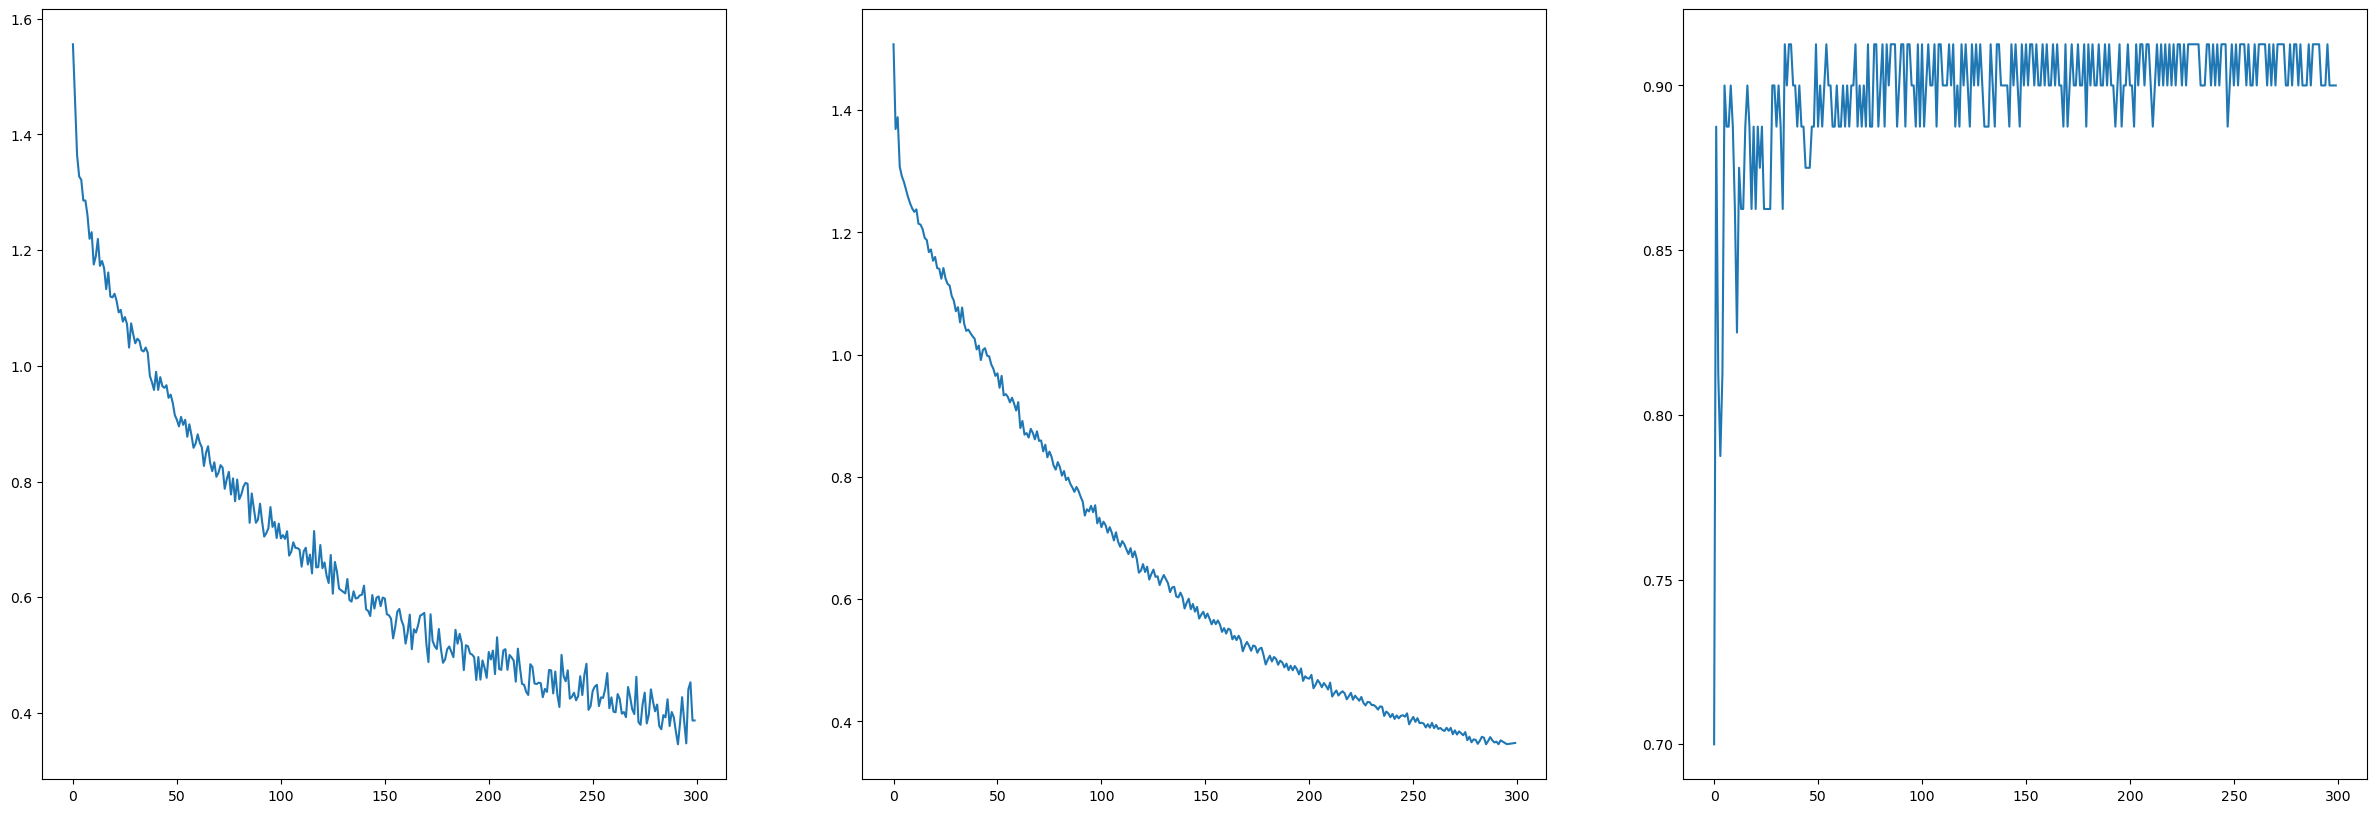

In [40]:
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-22]:
  layer.trainable = False
tfinput = Input(shape=(img_height,img_width,3))
# data_augment = data_augmentation(tfinput)
pre_process = preprocessing(tfinput)
inceptionv3_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(inceptionv3_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model_fine = Model(tfinput,output)
model_fine.summary()
new_dict = {'Epoch','train_loss','train_accuracy','val_loss','val_accuracy'}
log = open('INbreast_resnet50_finetuning.csv', 'a')
writer = csv.writer(log)
writer.writerow(new_dict)
log.close()
model.save_weights("/home/jj/FYP/Checkpoint/Resnet50_INbreast_roi/dense_init_checkpoint/best_model")
optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
model_fine.compile(
    optimizer= optimiser,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-6,verbose=1)
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
with tf.device('/GPU:0'):
    total_epochs=300
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model_fine.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        val_categorical_accuracy = history.history['val_categorical_accuracy'][-1]
        loss = history.history['loss'][-1]
        categorical_accuracy = history.history['categorical_accuracy'][-1]
        all_history['train_loss'].append(loss)
        all_history['train_acc'].append(categorical_accuracy)
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(val_categorical_accuracy)
        patience = 10
        log = open('INbreast_resnet50_finetuning.csv', 'a')
        writer = csv.writer(log)
        new_dict = [i+1,history.history['loss'][-1],history.history['categorical_accuracy'][-1],val_loss,history.history['val_categorical_accuracy'][-1]]
        # writer = csv.DictWriter(log, fieldnames=list(new_dict.keys()))
        writer.writerow(new_dict)
        log.close()
        Earlystop = 40
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model_fine.get_weights()
            model_fine.save_weights("/home/jj/FYP/Checkpoint/Resnet50_INbreast_roi/fine_tuning_checkpoint_loss/best_model")
            best_val_loss = val_loss
            patience_counter = 0
            earlystop_counter = 0
        else:
            patience_counter += 1
            earlystop_counter +=1
        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model_fine
            model_fine.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser.lr > min_lr:
                optimiser.lr = optimiser.lr * 0.1
            # Reset the patience counter
            patience_counter = 0
        if earlystop_counter == Earlystop:
            print(f'Early Stop at Epoch: {i+1}')
            break
# model_fine.set_weights(best_weights)
# model_fine.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_loss/best_model")

plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

In [42]:
model_fine.load_weights('/home/jj/FYP/Checkpoint/Resnet50_INbreast_roi/fine_tuning_checkpoint_loss/best_model')
eval = model_fine.evaluate(test_ds)

5/5 [==============================] - 1s 98ms/step - loss: 0.4954 - categorical_accuracy: 0.8889 - precision: 1.0000 - precision_1: 0.7333


# VGG16

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                             

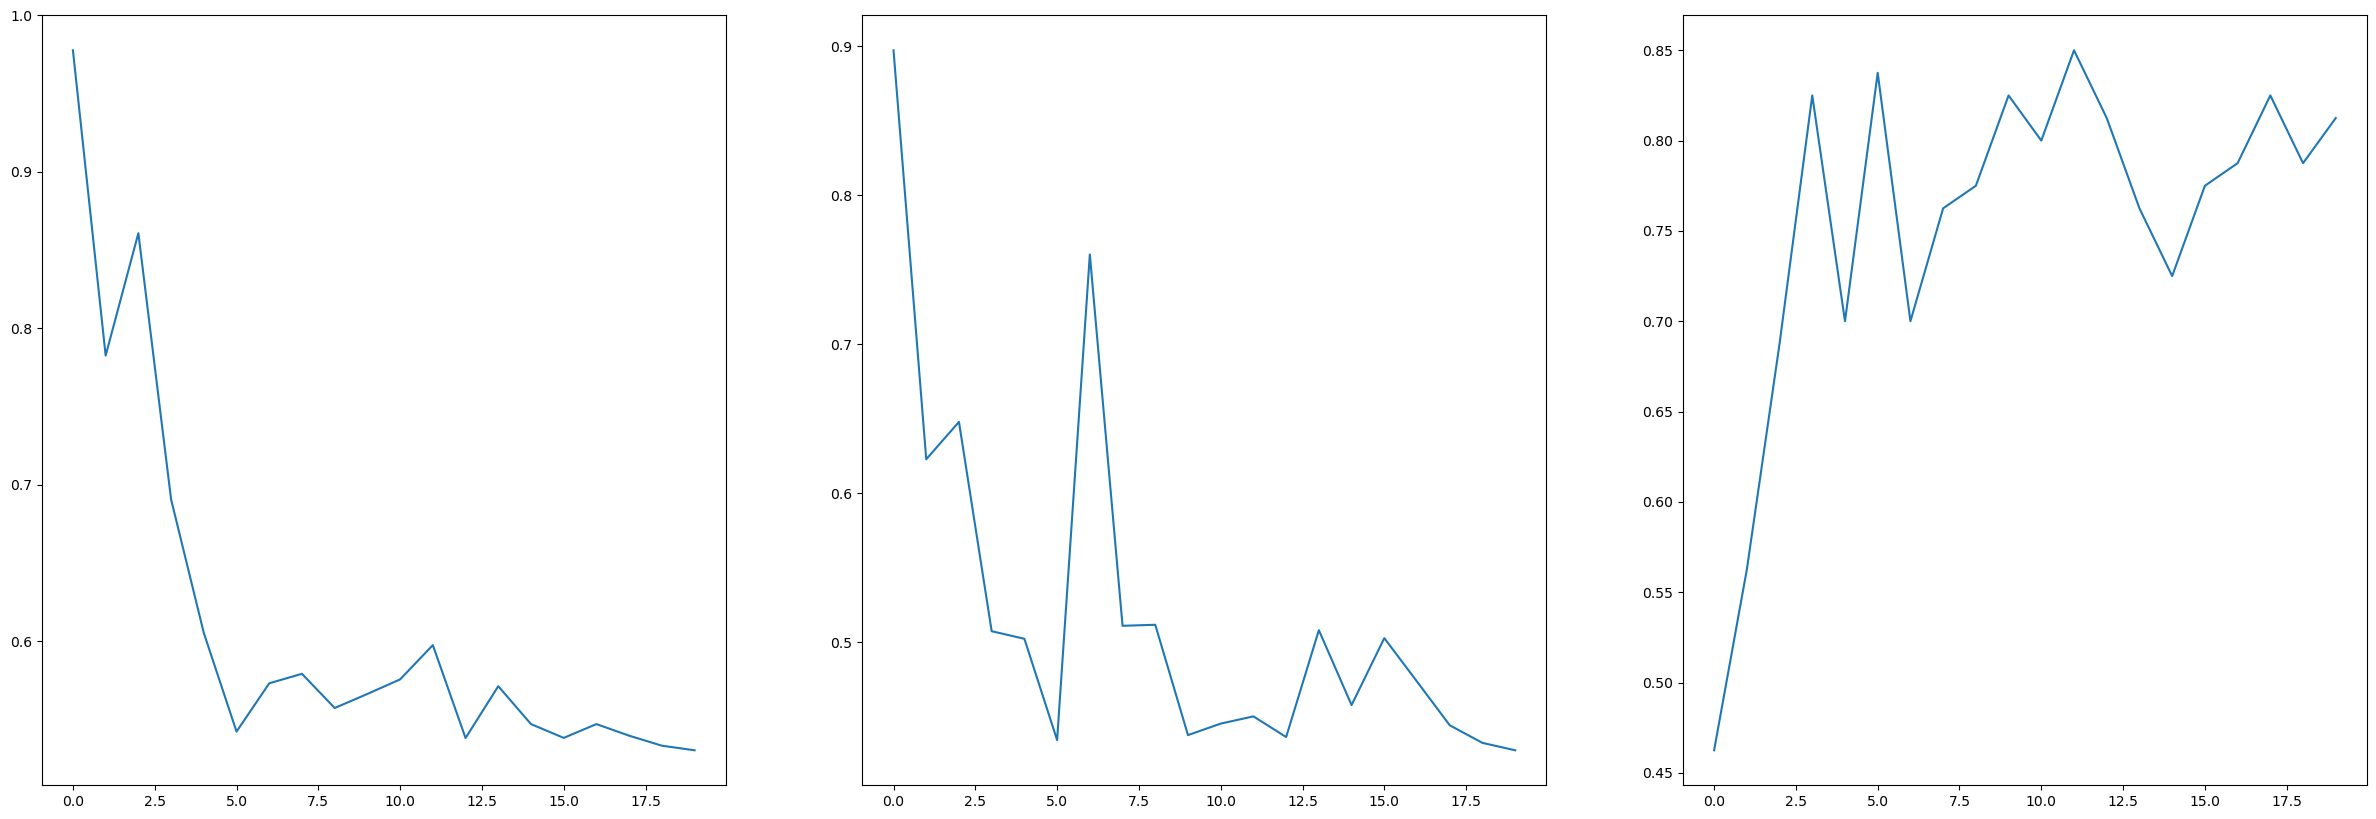

In [44]:
preprocessing = tf.keras.applications.vgg16.preprocess_input
pre_trained = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
pre_trained.trainable = False
#Define model architect
tfinput = Input(shape=(img_height,img_width,3))
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
effnet_2M_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(effnet_2M_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu')(x)
# ,kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model = Model(tfinput,output)
model.summary()
optimiser_Adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer= optimiser_Adam,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.AUC()]
    # ,jit_compile=True
)
new_dict = {'Epoch','train_loss','train_accuracy','val_loss','val_accuracy'}
log = open('INbreast_vgg16_dense_training.csv', 'a')
writer = csv.writer(log)
writer.writerow(new_dict)
log.close()
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
# Progress_bar = tf.keras.callbacks.ProgbarLogger()
# to_CSV = tf.keras.callbacks.CSVLogger('INbreast_InceptionV3_Dense_Training')
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
with tf.device('/GPU:0'):
    total_epochs=20
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser_Adam.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        all_history['train_loss'].append(history.history['loss'][-1])
        all_history['train_acc'].append(history.history['categorical_accuracy'][-1])
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(history.history['val_categorical_accuracy'][-1])
        patience = 1
        log = open('INbreast_vgg16_dense_training.csv', 'a')
        new_dict = {'Epoch':i+1,'train_loss':history.history['loss'][-1],'train_accuracy':history.history['categorical_accuracy'][-1],
        'val_loss':val_loss,'val_accuracy':history.history['val_categorical_accuracy'][-1]}
        writer = csv.DictWriter(log, fieldnames=list(new_dict.keys()))
        writer.writerow(new_dict)
        log.close()
        patience = 1
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model.get_weights()
            model.save_weights("/home/jj/FYP/Checkpoint/VGG16_INbreast_roi/dense_init_checkpoint/best_model")
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model
            model.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser_Adam.lr > min_lr:
                optimiser_Adam.lr = optimiser_Adam.lr * 0.9
            # Reset the patience counter
            patience_counter = 0
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 8)                 331784    
                                                             

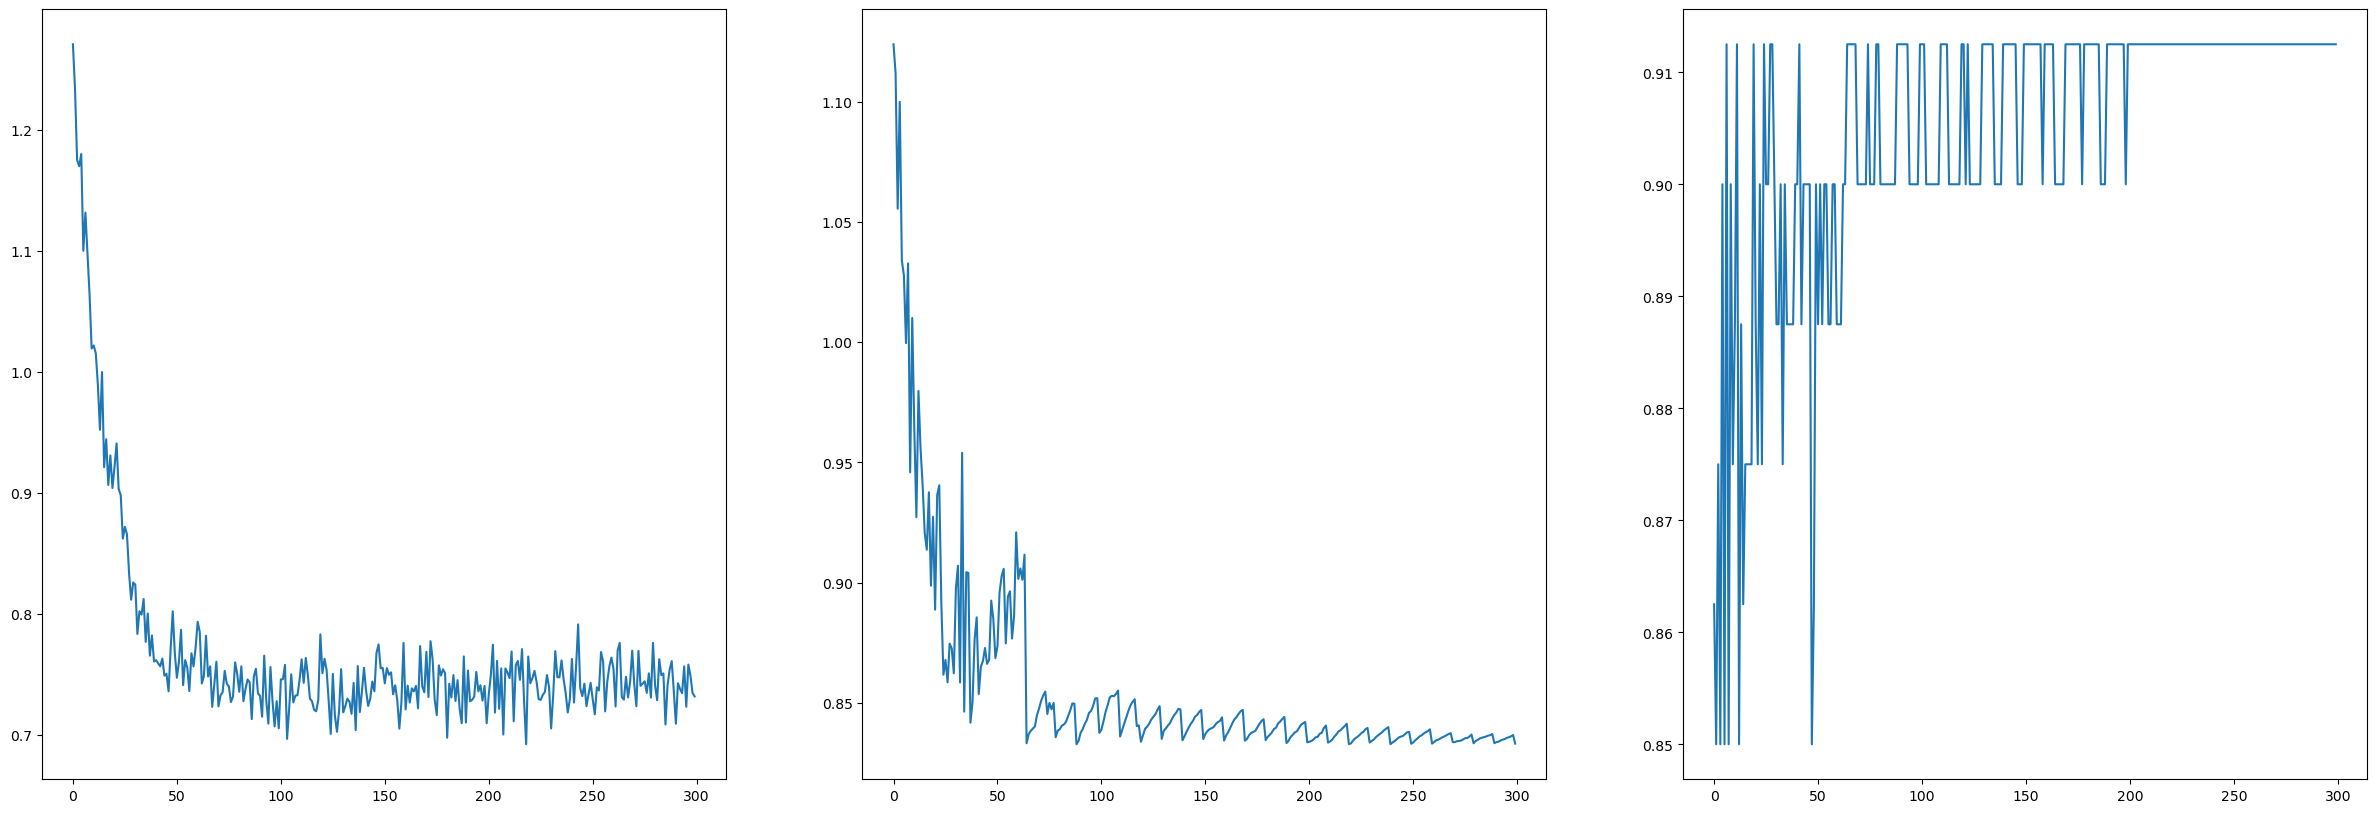

In [45]:
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-12]:
  layer.trainable = False
tfinput = Input(shape=(img_height,img_width,3))
# data_augment = data_augmentation(tfinput)
pre_process = preprocessing(tfinput)
vgg16_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(vgg16_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model_fine = Model(tfinput,output)
model_fine.summary()
new_dict = {'Epoch','train_loss','train_accuracy','val_loss','val_accuracy'}
log = open('INbreast_VGG16_FineTuning.csv', 'a')
writer = csv.writer(log)
writer.writerow(new_dict)
log.close()
model_fine.load_weights("/home/jj/FYP/Checkpoint/VGG16_INbreast_roi/dense_init_checkpoint/best_model")
optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
model_fine.compile(
    optimizer= optimiser,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-6,verbose=1)
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
with tf.device('/GPU:0'):
    total_epochs=300
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model_fine.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        val_categorical_accuracy = history.history['val_categorical_accuracy'][-1]
        loss = history.history['loss'][-1]
        categorical_accuracy = history.history['categorical_accuracy'][-1]
        all_history['train_loss'].append(loss)
        all_history['train_acc'].append(categorical_accuracy)
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(val_categorical_accuracy)
        patience = 10
        log = open('INbreast_VGG16_FineTuning.csv', 'a')
        writer = csv.writer(log)
        new_dict = [i+1,history.history['loss'][-1],history.history['categorical_accuracy'][-1],val_loss,history.history['val_categorical_accuracy'][-1]]
        # writer = csv.DictWriter(log, fieldnames=list(new_dict.keys()))
        writer.writerow(new_dict)
        log.close()
        earlystop_counter = 0
        Earlystop = 40
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model_fine.get_weights()
            model_fine.save_weights("/home/jj/FYP/Checkpoint/VGG16_INbreast_roi/fine_tuning_checkpoint_loss/best_model")
            best_val_loss = val_loss
            earlystop_counter = 0
        else:
            patience_counter += 1
            earlystop_counter +=1
        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model_fine
            model_fine.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser.lr > min_lr:
                optimiser.lr = optimiser.lr * 0.9
            # Reset the patience counter
            patience_counter = 0
        if earlystop_counter == Earlystop:
            print(f'Early Stop at Epoch: {i+1}')
            break
# model_fine.set_weights(best_weights)
# model_fine.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_loss/best_model")

plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

In [46]:
model_fine.load_weights('/home/jj/FYP/Checkpoint/VGG16_INbreast_roi/fine_tuning_checkpoint_loss/best_model')
eval = model_fine.evaluate(test_ds)

5/5 [==============================] - 2s 365ms/step - loss: 0.8730 - categorical_accuracy: 0.8333 - precision: 0.9130 - precision_1: 0.6923
